# **Chap8：Boosting和梯度提升**

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
colors = sns.palettes.color_palette("muted")

本章我们介绍第二大类集成学习方法**Boosting**，与**Bagging**类似，我们依然需要基于数据训练得到 $B$ 个基学习器，单个基学习器的性能可能较弱，但将它们组合后，就将成为一个强大的学习器，**Boosting**的组合方法是将基学习器的预测结果**“加和”**，即：
$$
f(x) = \sum_{b=1}^{B}\alpha_b E_b(x)
$$

其中，$\alpha_b$ 是各个基学习器的权重，对于回归问题，$f(x)$ 即为所求，对于分类问题，还需要取符号函数：
$$
f(x) = \text{sign}\left( \sum_{b=1}^{B}\alpha_b E_b(x) \right)
$$

## **1 AdaBoost**

**Boosting**方法又称为**提升方法**，历史上，Kearns 和 Valiant 首先提出了 **“强可学习”** 和 **“弱可学习”** 的概念，指出在**概率近似正确**（Probably Approximately Correct，**PAC**）学习框架中，一个概念（一个类），如果存在一个**多项式的时间的学习算法**能够学习它，并且正确率很高，则称为这个概念是**强可学习的**；反之，如果学习的正确率**仅比随即猜测好**，则称这个概念是**弱可学习的**，更更重要的是他们发现了下面定理：

**(Thm) 强可学习和弱可学习关系**：在PAC学习框架下，一个概念是强可学习的充分必要条件是这个概念是弱可学习的

在任务中，**弱学习器是比较容易发现**的，那么上述定理启发了Boost思想，在学习中，如果已经发现了弱学习算法，该如何**将其提升(Boost)为强学习算法**

### **1.1 AdaBoost方法**

AdaBoost是处理**分类问题**的提升方法，基本思想是：
* 对于分类问题，给定训练样本集 $D$，找到一个粗糙的分类规则（弱分类器）要比精确分类（强学习器）容易得多
* 从弱学习器出发，反复学习弱分类器，获得基学习器，然后组合它们
* 在每轮基学习器的训练时，**根据之前学习器的学习结果，调整数据的概率分布（权重）**，因此不同基学习器的学习结果不同

因此，AdaBoost关心的问题包括两个：
* 每一轮训练如何改变数据的权重，或者说概率分布
* 如何将这些弱学习器组合为强学习器

针对**数据权重**的改变，直观想法是，**增大上一轮模型预测错误样本的权重**，**减小上一轮模型预测正确样本的权重**，使下一轮模型更注重这部分样本的学习

针对**组合学习器**，直观想法是，**正确率越高的基学习器在最终的预测中应该有更多的话语权**

基于上面思想，我们直接叙述AdaBoost算法，先对算法流程有直观了解，下一节中我们再仔细讨论**Adaboost的机器学习三要素**，加深Boosting方法的认知

**(Algo) AdaBoost**  
* **输入**：训练数据集 $D = \{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i\in\mathbb{R}^p$，$y_i\in\mathcal{Y}=\{-1,+1\}$，弱学习算法 $G$
* **输出**：最终分类器 $f(x)$
* **算法流程**：
    * (1) 初始化训练数据的权值分布 $W_1 = (w_{1,1},\cdots,w_{1,N})$，其中 $w_{1,i} = 1/N,\quad i=1,2,\cdots,N$
    * (2) 对 $b=1,2,\cdots,B$：
        * (2.1) 使用具有样本权重 $W_b$ 的训练样本训练弱学习器，得到基学习器 $G_b(x)$：
        $$ G_b(x) : \mathcal{X}\to \{-1,+1\} $$
        * (2.2) 计算 $G_b(x)$ 再训练数据集上的分类误差率 $e_b$：
        $$
        e_b = \sum_{i=1}^{N} w_{b,i}\cdot \mathbb{I}(G_b(x_i)\ne y_i)
        $$
        * (2.3) 计算基学习器 $G_b(x)$ 组合时的权重 $\alpha_b$：
        $$
        \alpha_b = \frac{1}{2}\log{ \frac{1-e_b}{e_b} }
        $$
        * (2.4) 更新训练数据集的样本权重 $W_{b+1}$：
        $$
        W_{b+1} = (w_{b+1,1},\cdots,w_{b+1,N})\\
        w_{b+1,i} = \frac{w_{b,i}}{Z_b}\exp\left( -\alpha_b y_i G_b(x_i) \right),\quad i=1,2,\cdots,N
        $$
        其中，$Z_b$ 是规范化因子，让权重规范化到 $[0,1]$，从而使 $W_{b+1}$ 构成一个概率分布：
        $$
        Z_b = \sum_{i=1}^{N} w_{b,i} \exp\left( -\alpha_b y_i G_b(x_i) \right)
        $$
    * (3) 组建基学习器的线性组合，然后得到最终的预测函数 $f(x)$：
    $$
    f(x) = \text{sign}\left(G(x)\right) = \text{sign}\left( \sum_{b=1}^{B} \alpha_b G_b(x) \right)
    $$

我们对上述算法的一些细节做说明

**(1）样本权重** $W_b$

样本权重是我们在之前的讨论中未提及到的概念，事实上，在之前的学习中我们都**假设样本是等权重的**，即

$$
w_i = \frac{1}{N},\quad i=1,\cdots,N
$$

不同的样本权重 $W = (w_1,\cdots,w_N)$ 将作用到学习算法的损失函数中，例如对于**回归问题**，假设损失函数是**均方误差**，则带权重的损失函数为：

$$
L(X,Y) = \sum_{i=1}^{N} w_i\left( y_i - f(x_i) \right)^2
$$

如果模型 $f(x)$ 是**线性回归**，上述损失函数导出的模型又称为**加权最小二乘回归**

对于分类问题，假设类别数为 $K$，同样可以**在对数似然函数中引入样本权重**，得到

$$
L = \sum_{i=1}^{N} w_i\left(\sum_{k=1}^{K} \mathbb{I}(y_i = k)\log\left( \Pr(f(x_i) = k) \right) \right)
$$

**样本权重的加入会使得不同样本在损失函数中的贡献不同**，使得模型在优化过程中对不同样本有不同的关注力

**(2) 组合学习器的权重** $\alpha_b$

注意，每个基学习器在最终预测中的贡献是 $\alpha_b$：

$$
\alpha_b = \frac{1}{2} \log\frac{1-e_b}{e_b}
$$

其中，$e_b\in [0,1] $ 是错误分类率，我们绘制 $a_b$ 关于 $e_b$ 的函数如下所示

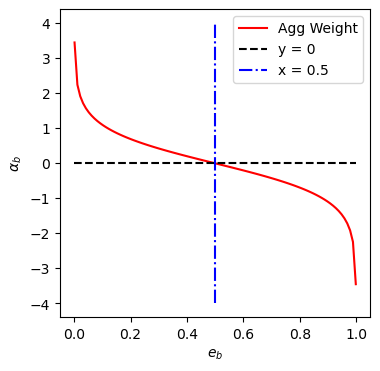

In [2]:
# 绘制组合权重关于 e_b 的函数
e_b = np.linspace(1e-3,1-1e-3,100)
alpha = 0.5*np.log((1 - e_b) / e_b)
fig = plt.figure(figsize=(4,4))
plt.plot(e_b,alpha,color="red",label="Agg Weight")
plt.hlines(0,0,1,color="black",ls='--',label="y = 0")
plt.vlines(0.5,-4,4,color="blue",ls='-.',label="x = 0.5")
plt.xlabel("$e_b$")
plt.ylabel("$\\alpha_b$")
plt.legend()

从图中可以看到以下事实：
* 当错误分类率 $e_b < 0.5$ 时，$G_b(x)$ 在最终预测函数 $f(x)$ 所做的是正贡献，且 $e_b(x)$ 越小，**权重越大，话语权越大**
* 当错误分类率 $e_b > 0.5$ 时，只需要**反着** $G_b(x)$ **的预测**，**就能够获得一个性能更好的模型**，错误分类率下降为 $1 - e_b$，因此其权重 $\alpha_b < 0$，代表着聚合时，考虑当前 $G_b(x)$ 相反的结果，设想如果一个模型如果能100%预测错误，那么反向预测就能获得100%的正确率
* 当错误分类率 $e_b = 0.5$ 时，此时得到了**最无用的模型**，模型的预测等同于随机猜测，因此在组合时分配给它的权重为 0

**(3) 关于样本权重的更新**

注意到第 $i$ 个样本在下一轮学习中，权重的更新公式为：

$$
w_{b+1,i} = \frac{w_{b,i}}{Z_b} \exp\left(-\alpha_b\cdot [y_i\cdot G_b(x_i)]  \right)
$$

我们单独考虑 $y_i\cdot G_b(x_i)$，注意到：

$$
y_i\cdot G_b(x_i) = \left\{
\begin{array}{ll}
1, & \text{此轮基学习器预测正确} \\
-1, & \text{此轮基学习器预测错误} 
\end{array}
\right.
$$

假设当前的基学习器 $G_b(x)$ 的**预测方向是正确的**，即 $e_b < 0.5,\alpha_b > 0$，则有：
* 如果样本 $x_i$ 预测正确，则下一轮权重被更新为：
$$ 
w_{b+1,i} = \frac{w_{b,i}}{Z_b}\exp(-\alpha_b) < w_{b,i}
$$
即预测正确的样本，在下一轮的权重将会被减小
* 同理，如果样本 $x_i$ 预测错误，则下一轮权重被更新为：
$$ 
w_{b+1,i} = \frac{w_{b,i}}{Z_b}\exp(\alpha_b) > w_{b,i}
$$
即预测错误的样本，在下一轮的权重将会被增大
* 减小/增大幅度 $e^{-\alpha_b},e^{\alpha_b}$ 与当前基学习器的误分类率 $e_b$ 有关，$e_b$ 越小，$\alpha_b$ 越大，$\alpha_b$ **越大说明当前基学习器** $G_b(x)$ 是一个**强大的学习器**，则被它**正确分类的样本不再需要过多关注**，它已经有把握了，因此用 $e^{-\alpha_b}$ **大幅缩减**它在之后的权重；被它**错误分类的样本需要特别关注**，需要**依靠之后的学习器捕捉**，因此用 $e^{\alpha_b}$ 大幅增大错误样本在之后的权重

对于当前学习器 $G_b(x)$ 的预测方向相反，即 $e_b > 0.5$ 的情况分析与上面类似，而**对于** $e_B = 0.5$ **的基学习器，它无法改变样本权重**

需要指明，**Boosting**算法在集成基学习器时，下一个基学习器的训练需要依靠上一轮的结果，因此这是一种**串行**方法，这是**Boosting**与**Bagging**的一个显著区别，因此**Boosting**方法的训练无法并行，效率相对较低

### **1.2 AdaBoost的机器学习三要素**

事实上，下面关于AdaBoost的建模优化理论介绍是在AdaBoost方法提出5年后才被发现的，但这套理论的提出非常重要，这是后续各类Boosting方法的基础

**(1) AdaBoost模型**

假设我们要组合 $B$ 个基学习器 $G_b(x;\gamma_b)$，其中 $\gamma_b$ 表示基学习器 $G_b(x)$ 的参数：
* 例如对于逻辑回归，$\gamma_b$ 就是回归系数 $\beta$
* 例如对于决策树CART，$\gamma_b$ 就代表模型的分裂结构、分裂特征和切分点的选择

AdaBoost采用**加法模型**，最后的决策函数可以表示为：

$$
f(x) = \sum_{b=1}^{B}\alpha_b G_b(x;\gamma_b)
$$

其中，$\alpha_b\in\mathbb{R}$ 表示组合基学习器的权重，假设每个基学习器 $G_b(x;\gamma_b)$ 的参数空间为 $\Theta$

则AdaBoost模型的假设空间 $\mathcal{F}$ 可以写作

$$
\mathcal{F} = \{ f(x) = \sum_{b=1}^{B}\alpha_b G_b(x;\gamma_b) | \alpha_b\in\mathbb{R},\gamma_b\in\Theta,b=1,\cdots,B \}
$$

**(2) AdaBoost策略**

AdaBoost使用的损失函数是**指数损失函数** $L(y,f(x))$：

$$
L(y,f(x)) = \exp\left( -yf(x) \right)
$$

对比我们在**SVM**部分对比的多个损失函数，思考该损失函数所表达的含义，注意其中 $yf(x)$ 表示**函数间隔**

AdaBoost的目标即为**极小化经验指数损失**：

$$
(\alpha_1^*,\cdots,\alpha_B^*,\gamma_1^*,\cdots,\gamma_B^*) = \mathop{\arg\min}\limits_{\alpha_b,\gamma_b \\b=1,\cdots,B} \sum_{i=1}^{N} \exp\left( -y_i\cdot \sum_{b=1}^{B} \alpha_b G_b(x;\gamma_b) \right)
$$

**(3) AdaBoost算法**

很显然，策略最后留下的极小化问题求解是极其困难的，对于**加法模型**，我们通常采用**前向分步算法**来获得问题的**次优解**

**前向分步算法的直觉**是：既然模型是加法模型，如果能够从前向后学习，**每步只学习一个基学习器及其参数**，**逐步逼近目标函数**，那么就可以简化优化的复杂度，因此，前向分步算法中，**下一步基函数的训练在前面几步已经完成训练的基函数的基础上进行，不会改变原有基函数的参数**，前向分步算法算法使得每一步的损失函数都会下降

这样，同时求解 $\alpha_1,\gamma_b,b=1,\cdots,B$ 的问题被拆分到逐个求解，下面展示具体的算法流程

**(Algo) 前向分步算法**  
* (1) 首先初始化决策函数 $f_0(x)=0$
* (2) 假设已经完成了 $b-1$ 轮的迭代，得到了 $f_{b-1}(x)$：
    $$
    f_{b-1}(x) = f_0(x) + \sum_{i=1}^{b-1} \alpha_i G_i(x;\gamma_)
    $$
    * 下面考虑第 $b$ 个基学习器的训练，求解 $\alpha_b,G_b(x;\gamma_b)$，从而：
    $$
    f_b(x) = f_{b-1}(x) + \alpha_b\cdot G_b(x;\gamma_b)
    $$
    * 对于损失函数 $L(y,f(x))$，根据前向分步算法的思想，我们求解优化问题：
    $$
    (\alpha_b,\gamma_b) = \mathop{\arg\min}\limits_{a,\gamma} \sum_{i=1}^{N} L(y_i,f_{b-1}(x_i) + a\cdot G_b(x;\gamma))
    $$
    **AdaBoost使用指数损失**，因此优化问题为：
    $$
    (\alpha_b,\gamma_b) = \mathop{\arg\min}\limits_{a,\gamma} \sum_{i=1}^{N} \exp\left( -y_i\cdot\left[f_{b-1}(x_i) + a\cdot G_b(x;\gamma)  \right] \right)
    $$
    * 对于单个学习器而言，上述问题是容易求解的，得到第 $b$ 个基学习器 $G_b(x;\gamma_b)$ 及其权重 $\alpha_b$
* (3) $B$ 个基学习器训练完成后，得到最终的预测函数 $f(x)$：

$$
f(x) = f_0(x) + \sum_{b=1}^{B}\alpha_b G_b(x;\gamma_b)
$$

下面我来来具体讨论AdaBoost的求解，在第 $b$ 步前向分步算法的求解中，我们令 $w_{b,i} = \exp[-y_i f_{b-1}(x_i)]$，则等价于优化：

$$
(\alpha_b,\gamma_b) = \mathop{\arg\min}\limits_{a,\gamma} \sum_{i=1}^{N} w_{b,i}\cdot \exp\left( -y_i a G_b(x_i;\gamma) \right)
$$

我们下面证明，上式求解得到的 $\alpha_b,G_b(x;\gamma_b)$ 就是**1.1节**中我们介绍的AdaBoost算法对应的权重和学习器

首先，对任意 $\alpha$，$w_{b,i}$ 与 $\alpha,G_b(x;\gamma)$ 都没有关系，最优的 $G_b(x;\gamma_b)$ 与 $\alpha$ 的值无关，先求解 $G_b(x;\gamma_b)$，我们是在**让误分类率最低**：

$$
\gamma_b = \mathop{\arg\min}\limits_{\gamma\in\Theta} \sum_{i=1}^{N} w_{b,i}\cdot \mathbb{I}(y_i\ne G_b(x;\gamma))
$$

$G_b(x;\gamma_b)$ 即为AdaBoost算法的基本分类器，因为它是使得第 $b$ 轮**加权训练数据分类误差率最小的基分类器**

接下来，考虑 $\alpha_b$，做如下变换：

$$
\begin{array}{rcl}
\displaystyle{ \sum_{i=1}^{N} w_{b,i}\exp[-y_i\alpha G_b(x_i;\gamma_b)] } & = & \displaystyle{ \sum_{y_i = G_b(x_i;\gamma_b)} w_{b,i}e^{-\alpha} + \sum_{y_i \ne G_b(x_i;\gamma_b)} w_{b,i}e^{\alpha} }\\
& = & \displaystyle{ \sum_{y_i = G_b(x_i;\gamma_b)} w_{b,i}e^{-\alpha} + \sum_{y_i \ne G_b(x_i;\gamma_b)} w_{b,i}e^{\alpha} - \sum_{y_i \ne G_b(x_i;\gamma_b)} w_{b,i}e^{-\alpha} + \sum_{y_i \ne G_b(x_i;\gamma_b)} w_{b,i}e^{-\alpha} } \\
& = & \displaystyle{ (e^\alpha - e^{-\alpha}) \sum_{i=1}^{N}w_{b,i}\cdot \mathbb{I}(y_i\ne G_b(x_i;\gamma_b)) + e^{-\alpha}\sum_{i=1}^{N}w_{b,i} }
\end{array}
$$

如果我们令 $e_b$ 为**分类错误率**：

$$
e_b = \frac{ \sum_{i=1}^{N} w_{b,i}\cdot \mathbb{I}(y_i\ne G_b(x_i;\gamma_b)) }{ \sum_{i=1}^{N}w_{b,i} }
$$

则上面的优化目标，等价于极小化：

$$
(e^{\alpha} - e^{-\alpha})e_b + e^{-\alpha}
$$

上式对 $\alpha$ 求导，并令导数等于0，得到：

$$
(e^{\alpha} + e^{-\alpha})e_b - e^{-\alpha} = 0\quad\Rightarrow\quad a^* = \frac{1}{2}\log\frac{1-e_b}{e_b}
$$

可以看到，这就是AdaBoost算法中，**基学习器组合权重** $\alpha_b$ **的计算公式**

最后，再来观察权重的更新，注意到：

$$
f_b(x) = f_{b-1}(x) + \alpha_b\cdot G_b(x),\quad w_{b,i} = \exp[-y_i f_{b-1}(x_i)]
$$

而在下一轮更新中：

$$
w_{b+1,i} = \exp[-y_i f_{b}(x_i)] = \exp[-y_i\cdot(f_{b-1}(x_i) + \alpha_b G_b(x_i))] = w_{b,i}\cdot \exp[-y_i \alpha_b G_b(x_i)]
$$

可以看到，这就是AdaBoost算法中，**每轮对样本权重的更新公式**，只是**没有进行权重标准化**，但标准化所使用的常数因子 $Z_b$ 不影响优化结果

综上所述，我们可以得出结论，**AdaBoost是Boosting方法在使用指数损失函数的特例**，它属于**Boosting加法模型的框架**中

### **1.3 AdaBoost的误差分析**

我们以AdaBoost为例，来展示Boosting方法在误差收敛控制时的优秀性质

**(Thm) AdaBoost的训练误差界**：AdaBoost算法最终分类器的训练误差界为：
$$
\frac{1}{N}\sum_{i=1}^{N}\mathbb{I}(y_i\ne f(x_i)) \leq \frac{1}{N}\sum_{i=1}^{N} \exp(-y_i G(x_i)) = \prod_{b=1}^{B} Z_b
$$
其中：
$$
f(x) = \text{sign}\left( G(x) \right) = \text{sign}\left( \sum_{b=1}^{B}\alpha_b G_b(x) \right)
$$

**证明**：当 $f(x_i)\ne y_i$ 时，函数间隔 $y_iG(x_i) < 0$，因此 $\exp(-y_iG(x_i)) \geq 1$，前半部分的不等式得证

后半部分，注意 $w_{b,i}$ 的更新公式有：
$$
w_{b,i}\cdot\exp[-\alpha_b y_iG_b(x_i)] = Z_b\cdot w_{b+1,i}
$$

因此，计算可得：

$$
\begin{array}{rcl}
\displaystyle{ \frac{1}{N}\sum_{i=1}^{N}\exp(-y_i G(x_i)) } & = & \displaystyle{ \frac{1}{N}\sum_{i=1}^{N}\exp\left(-\sum_{b=1}^{B}\alpha_b y_i G_b(x_i) \right) } \\
& = & \displaystyle{ \sum_{i=1}^{N} w_{1,i} \prod_{b=1}^{B} \exp\left(-\alpha_b y_i G_b(x_i) \right) }\\
& = & \displaystyle{ \sum_{i=1}^{N} w_{1,i} \exp\left(-\alpha_1 y_i G_1(x_i) \right) \prod_{b=2}^{B} \exp\left(-\alpha_b y_i G_b(x_i) \right) }\\
& = & \displaystyle{ \sum_{i=1}^{N} Z_1\cdot w_{2,i} \prod_{b=2}^{B} \exp\left(-\alpha_b y_i G_b(x_i) \right) }\\
& = & \displaystyle{ Z_1\cdot \sum_{i=1}^{N} w_{2,i} \prod_{b=2}^{B} \exp\left(-\alpha_b y_i G_b(x_i) \right) }\\
& = & \displaystyle{ Z_1Z_2 \cdot \sum_{i=1}^{N} w_{3,i} \prod_{b=3}^{B} \exp\left(-\alpha_b y_i G_b(x_i) \right) }\\
& = & \displaystyle{\cdots } \\
& = & \displaystyle{ \prod_{b=1}^{B}Z_b }\\
\end{array}
$$

上面定理启发我们，在每一轮训练时，选择适当的 $G_b(x)$ 使得 $Z_b$ 最小，可以让整体训练误差的下降速度最快

对于二分类问题，有如下的定理

**(Thm) 二分类问题的AdaBoost训练误差界**：对于二分类问题，有：
$$
\prod_{b=1}^{B}Z_b = \prod_{b=1}^{B} [2\sqrt{e_b(1-e_b)}] = \prod_{b=1}^{B} \sqrt{(1 - 4\gamma_b^2)}\leq \exp\left( -2\sum_{b=1}^{B}\gamma_b^2 \right)
$$
其中，$\gamma_b$为：
$$
\gamma_b = \frac{1}{2} - e_b
$$

**证明**：由 $Z_b$ 的定义出发，有：

$$
\begin{array}{rcl}
\displaystyle{ Z_b } & = & \displaystyle{ \sum_{i=1}^{N} w_{b,i} \exp[-\alpha_b y_i G_b(x_i)] } \\
& = & \displaystyle{ \sum_{y_i = G_b(x_i)} w_{b,i}e^{-\alpha_b} + \sum_{y_i \ne G_b(x_i)} w_{b,i}e^{\alpha_b}  } \\
& = & \displaystyle{ (1-e_b)e^{-\alpha_b} + e_b e^{\alpha_b} }
\end{array}
$$

我们代入 $\alpha_b$：
$$
\alpha_b = \frac{1}{2}\log\frac{1-e_b}{e_b}
$$

得到：

$$
Z_b = (1-e_b) (\frac{1-e_b}{e_b})^{-1/2} + e_b (\frac{1-e_b}{e_b})^{1/2} = 2\sqrt{e_b(1-e_b)} = \sqrt{4e_b(1-e_b)} = \sqrt{4\times (\frac{1}{2}-\gamma_b)(\frac{1}{2}+\gamma_b)} = \sqrt{1 - 4\gamma_b^2}
$$

最后借助不等式 $\sqrt{1-2x}\leq \exp(-x)$（可以利用在 $x=0$ 处泰勒展开证明），得到：

$$
\prod_{b=1}^{B} \sqrt{1 - 4\gamma_b^2} \leq \exp\left( -2\sum_{b=1}^{B}\gamma_b^2 \right)
$$

如果存在 $\gamma > 0$ 使得对所有 $b=1,\cdots,B$，有 $\gamma_b \geq g$，则有：

$$
\frac{1}{N}\sum_{i=1}^{N}\mathbb{I}(y_i \ne f(x_i)) \leq \exp\left( -2B\gamma^2 \right)
$$

上式表明，**AdaBoost的训练误差是以指数速度下降的**，这一点非常有吸引力

需要说明，**在使用AdaBoost时，我们并不需要在意性能下界** $\gamma$，它是**自适应的**，这正是它名称的由来（**Adaptive Boosting**），算法框架能够适应弱分类器各自的训练误差率

到此，我们介绍了分类任务的最后一种损失函数**指数损失**，我们将它加入到SVM时讨论的各种二分类损失函数中，再次进行比较，观察损失函数曲线，比较各个算法的异同，注意，**指数损失**同样是分类问题**0-1损失**的**代替损失函数**

In [3]:
# 设置函数间隔的范围
yf = np.linspace(-1,2,200)
loss = {}
# 0-1 损失
loss["0-1 Loss"] = np.zeros_like(yf)
loss["0-1 Loss"][yf < 0] = 1
# 感知机损失
loss["Inceptron Loss"] = np.zeros_like(yf)
loss["Inceptron Loss"][yf < 0] = -yf[yf < 0]
# 合页损失
loss["Hinge Loss"] = np.zeros_like(yf)
loss["Hinge Loss"][yf < 1] = 1 - yf[yf < 1]
# 二项偏差损失，Logistic损失，做了标准化，使其通过点 (0,1)
loss["Logistic Loss"] = np.log(1 + np.exp(-yf)) / np.log(2)
# 平方损失
loss["Square Loss"] = (1 - yf)**2
# 指数损失
loss["Exponential Loss"] = np.exp(-yf)

Text(0, 0.5, 'Loss')

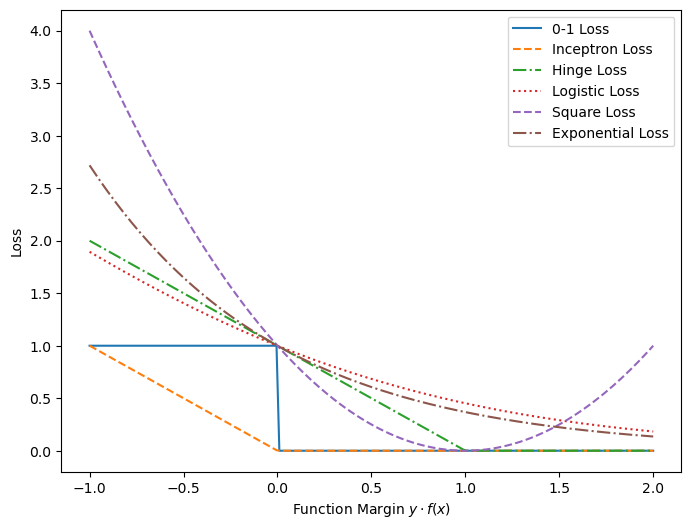

In [4]:
fig = plt.figure(figsize=(8,6))
linestyle = ["-", "--", "-.", ":", "--","-."]
for i,(name,l) in enumerate(loss.items()):
    plt.plot(yf,l,label=name,lw=1.5,ls=linestyle[i])
plt.legend()
plt.xlabel("Function Margin $y\cdot f(x)$")
plt.ylabel("Loss")

### **1.4 提升树**

提升树就是以CART树为基学习器的Boosting方法，提升树目前仍然是统计学习模型中性能最好的方法之一

提升树模型可以表示为决策树的加法模型：

$$
f(x) = \sum_{b=1}^B T(x;\Theta_b)
$$

其中，$T(x;\Theta_b)$ 表示决策树，$\Theta_b$ 作为决策树参数

提升树模型依然采用**前向分步算法**来完成求解，第 $b$ 步的模型为：
$$
f_b(x) = f_{b-1}(x) + T(x;\Theta_b)
$$

假设损失函数是 $L(y,f(x))$，利用经验风险最小化策略决定下一棵决策树：

$$
\Theta_b = \mathop{\arg\min}\limits_{\Theta} \sum_{i=1}^{N} L\left( y_i,f_{b-1}(x_i) + T(x_i;\Theta) \right)
$$

**由于树的线性组合可以很好拟合训练数据，即使数据中的输入与输出之间有很强的非线性关系也是如此**，通常来说，提升树的性能都很强

**(1) 分类问题**

我们可以取上面介绍的**指数损失** $L(y,f(x)) = \exp(-yf(x))$，则**分类提升树完全等价于使用决策树作为基学习器的AdaBoost模型**，可以说**此时的提升树是AdaBoost模型的特殊情况**，因此不再做过多叙述

**(2) 回归问题**

下面，我们来考虑回归问题，假设训练数据 $D=\{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i\in\mathbb{R}^p$，标签 $y_i\in\mathbb{R}$

此时在前向分步算法的第 $b$ 步时，给定当前模型 $f_{b-1}(x)$，需要求解：

$$
\Theta_b = \mathop{\arg\min}\limits_{\Theta} \sum_{i=1}^{N} L\left( y_i,f_{b-1}(x_i) + T(x_i;\Theta) \right)
$$

假设所使用的损失函数是**平方损失**，即 $L(y,f(x)) = [y - f(x)]^2$，则：

$$
L\left( y_i,f_{b-1}(x_i) + T(x_i;\Theta) \right) = \left[ y - f_{b-1}(x) - T(x;\Theta) \right]^2 = \left[r - T(x;\Theta)\right]^2
$$

其中，$r$ 表示当前模型估计的残差：
$$
r = y - f_{b-1}(x)
$$

所以，**对使用平方误差作为损失函数的回归提升树而言，每一个基学习器只需要拟合当前模型预测的残差**，算法变得相当简单

**(Algo) 回归提升树**  
* **输入**：训练数据 $D=\{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i\in\mathbb{R}^p$，标签 $y_i\in\mathbb{R}$。基学习器个数 $B$
* **输出**：回归提升树 $f(x)$
* **算法流程**：
    * (1) 初始化 $f_0(x) = 0$
    * (2) 对 $b=1,2,\cdots,B$
        * (2.1) 计算残差 $r_{b,i}$：
        $$
        r_{b,i} = y - f_{b-1}(x_i),\quad i=1,2,\cdots,N
        $$
        * (2.2) 拟合残差 $\{r_{b,i}\}_{i=1}^{N}$ 得到一棵决策树 $T(x;\Theta_b)$
        * (2.3) 更新模型，$f_b(x) = f_{b-1}(x) + T(x;\Theta_b)$
    * (3) 所有基学习器拟合完成后，最终的决策函数为：
    $$
    f(x) = \sum_{b=1}^{B} T(x;\Theta_b)
    $$

### **1.5 AdaBoost实现**

我们最后来**实现AdaBoost算法**，并做一个简单的实验，来更清楚的说明算法背后的逻辑

首先，定义函数`train_base_estimator()`用于创建并训练每一步的基学习器：
* 我们**选定CART树**作为基学习器
* 我们限制基学习器的拟合能力，设置`max_depth = 2`，这样子每个基学习器就是一个**弱学习器**
* 基学习器的训练需要提供样本权重`weights`

In [5]:
def train_base_eatimator(X : np.ndarray, y : np.ndarray, weights : np.ndarray):
    """
    Parameters
    ----------
    X : np.ndarray
        样本特征，维度`(N,p)`
    y : np.ndarray
        样本标签，维度`(N,)`
    weights : np.ndarray
        样本权重，维度`(N,)`
    """
    # 训练模型
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(X,y,sample_weight=weights)
    # 计算误差率
    y_pred = model.predict(X)
    # 误差率 = 1 - 正确率，最后加上 1e-16 做数值保护
    error_rate = 1 - accuracy_score(y,y_pred) + 1e-16
    # 计算基学习器组合权重
    agg_weight = 0.5 * np.log((1 - error_rate) / error_rate)

    return model, error_rate, agg_weight

加下来，定义函数`adjust_sample_weights()`用于在每轮训练结束后，根据公式调整样本权重

In [6]:
def adjust_sample_weights(X : np.ndarray, y : np.ndarray, weights : np.ndarray, 
    model, agg_weight : float):
    """
    Parameters
    ----------
    X : np.ndarray
        样本特征，维度`(N,p)`
    y : np.ndarray
        样本标签，维度`(N,)`
    weights : np.ndarray
        样本权重，维度`(N,)`
    model : Any
        训练后的基学习器
    agg_weight : float
        当前基学习器的组合权重
    """
    # 基学习器预测
    Gx = model.predict(X)
    # 计算新权重
    weights = weights * np.exp(-agg_weight*y*Gx)
    weights /= weights.sum() # 归一化
    
    return weights

我们将上面两个函数封装到自定义的`MyAdBoost`类中，在拟合模型时调用它们，注意：
* 我们在类中需要保存每一步训练得到的**基学习器**，以及**基学习器组合权重**
* 我们害保存了每一步的**样本权重**，用于后面的可视化

In [7]:
class MyAdaBoost:
    def __init__(self, B : int) -> None:
        self.B = B
        self.base_estimators = [] # 保存基学习器
        self.agg_weights = [] # 保存基学习器组合权重
        self.samples_weghts = [] # 保存样本权重
    
    def fit(self, X : np.ndarray, y : np.ndarray):
        """
        训练模型
        """
        N = X.shape[0] # 样本量
        # 初始化样本权重为 1/N
        weights = np.ones(N) / N
        for b in range(self.B):
            # 创建基学习器，并训练
            self.samples_weghts.append(weights) # 保存样本权重
            model, error_rate, agg_weight =\
                train_base_eatimator(X,y,weights)
            # 更新样本权重
            weights = adjust_sample_weights(X,y,weights,model,agg_weight)

            # 保存基学习器信息
            self.base_estimators.append(model)
            self.agg_weights.append(agg_weight)
    
    def predict(self, X : np.ndarray):
        """
        进行预测
        """
        x_preds = []
        for model in self.base_estimators:
            x_preds.append(model.predict(X))
        # 每个基学习器在每个样本上做出预测
        # 维度 shape (N,B)
        x_preds = np.array(x_preds).T
        # 对每个样本，聚合基学习器的预测结果，并取符号函数 sign()
        preds = np.sign((x_preds*self.agg_weights).sum(axis=1))
        return preds

下面是我们的老朋友，用于可视化模型的决策边界，我们新增加了一个参数`weights`表示样本权重，**在绘图时，散点图每个元素的大小会根据样本权重进行调整**

In [8]:
def plot_decision_boundary(data, labels, clf, weights):
    """
    绘制决策边界
    
    Parameters
    ----------
    data : np.ndarray
        特征数据
    labels : np.ndarray
        数据集标签
    clf : Any
        训练后的分类器
    weights : np.ndarray
        样本权重
    """
    plot_step = 0.02
    x_min, x_max = data[:,0].min() -1, data[:,0].max() + 1
    y_min,y_max = data[:,1].min() -1 , data[:,1].max() + 1
    # 绘制决策边界
    xx,yy = np.meshgrid(np.arange(x_min,x_max,plot_step),
                        np.arange(y_min,y_max,plot_step))
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(4,4))
    cs = plt.contourf(xx,yy,Z,cmap=sns.cm.icefire,alpha=0.5)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')

    weights = weights.copy() # 拷贝样本权重
    weights *= 600 # 扩大适当倍数，以便于可视化，我们只在意权重的相对大小
    plt.scatter(data[labels==-1,0],data[labels==-1,1],s=weights[labels==-1],color=colors[0],label="Negative")
    plt.scatter(data[labels==1,0],data[labels==1,1],s=weights[labels==1],color=colors[1],label="Positive")
    plt.legend()

    # 打印正确率
    acc = accuracy_score(labels,clf.predict(data))
    print("正确率：%.4f"%(acc))

接下来，我们生成二分类数据集，然后进行实验

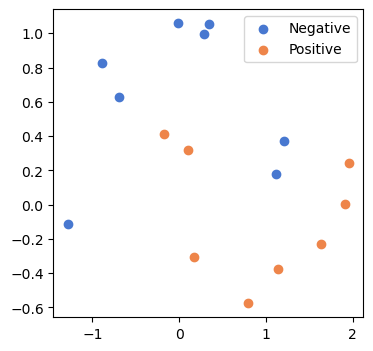

In [9]:
# 创建数据集
X,y = make_moons(n_samples=16,noise=0.2,random_state=40)
y[y==0] = -1 # 标签需要属于 {-1,+1}
fig = plt.figure(figsize=(4,4))
plt.scatter(X[y==-1,0],X[y==-1,1],color=colors[0],label="Negative")
plt.scatter(X[y==1,0],X[y==1,1],color=colors[1],label="Positive")
plt.legend()

创建我们自定义的AdaBoost模型实例，设置基学习器个数`B = 3`，然后拟合模型

In [10]:
# 创建AdaBoost模型，设置基学习器个数
boost_model = MyAdaBoost(B=3) 
boost_model.fit(X,y) # 拟合模型

接下来，我们利用决策界面可视化每一步**基学习器的训练效果**，及**样本权重的更新情况**，散点的**相对大小用于表示训练权重**

正确率：0.8750


Text(0.5, 1.0, 'Decision Boundary for BaseEstimator 1')

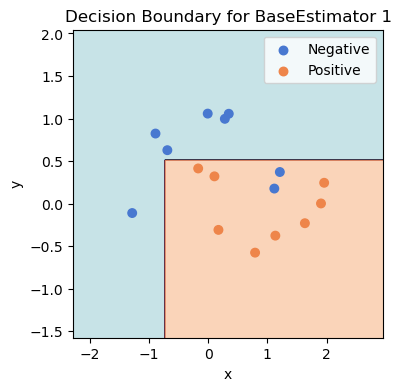

In [11]:
plot_decision_boundary(X,y,
    boost_model.base_estimators[0],boost_model.samples_weghts[0])
plt.title("Decision Boundary for BaseEstimator 1")

如上图，第一个基学习器拟合时，所有样本的**权重相等**，都是 $1/N$，此时**模型存在两个误分类样本**

正确率：0.8750


Text(0.5, 1.0, 'Decision Boundary for BaseEstimator 2')

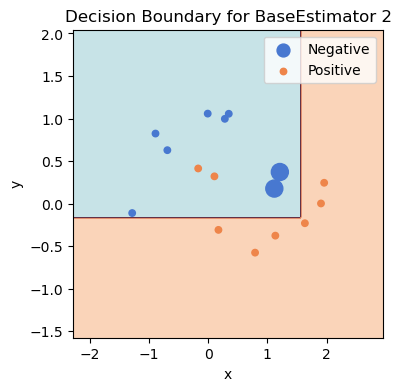

In [12]:
plot_decision_boundary(X,y,
    boost_model.base_estimators[1],boost_model.samples_weghts[1])
plt.title("Decision Boundary for BaseEstimator 2")

如上图，第二个基学习器拟合时，**误分类的两个样本权重增大，其他样本的权重都减小**，此时为了最小化损失，**第二个基学习器将偏向于着重处理两个误分类的样本**，可以看到第二个基学习器拟合后能正确分类这两个样本

但同时，模型又出现了新的两个误分类，它们交给第三个基学习器来处理

正确率：0.8750


Text(0.5, 1.0, 'Decision Boundary for BaseEstimator 3')

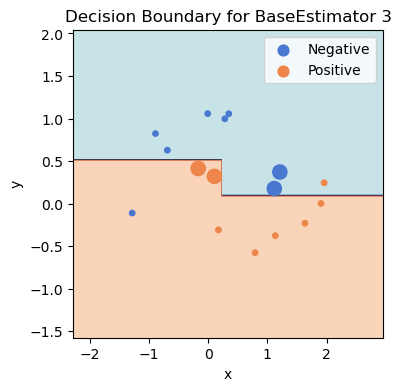

In [13]:
plot_decision_boundary(X,y,
    boost_model.base_estimators[2],boost_model.samples_weghts[2])
plt.title("Decision Boundary for BaseEstimator 3")

如上图，第三个基学习器拟合时，第二步被误分类的样本的权重增大，被正确分类样本的权重相对减小，**第三个基学习器着重处理这四个权重较大的样本**，拟合后的决策边界能够正确分类这四个样本

正确率：1.0000


Text(0.5, 1.0, 'Decision Boundary for AdaBoost Model')

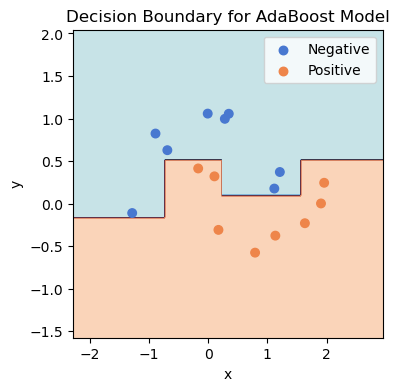

In [14]:
plot_decision_boundary(X,y,boost_model,boost_model.samples_weghts[0])
plt.title("Decision Boundary for AdaBoost Model")

最后，我们绘制综合三个基学习器的Boosting模型的决策边界会发现，**相比每个基学习器较弱的拟合能力，Boosting模型的决策边界可以更加复杂**，模型拥有**更强的非线性学习能力**，并且**训练集正确率也被提高到100%**

----

## **2 梯度提升方法和梯度提升树**

### **2.1 梯度提升方法GB (Gradient Boosting)**

#### **2.1.1 一般损失函数下的Boosting问题**

对于Boosting方法，我们在上一节介绍了当损失函数是**指数损失**和**平方损失**的情况下的算法：
* 指数损失对应**AdaBoost的特殊情况**
* 平方损失每个基学习器拟合之前学习器预测的**残差**

但损失函数不只有**指数损失**和**平方损失**，在不同的需求场景下，我们**有时会更换损失函数以获得更好的模型性能**

例如，我们知道对于一组数据 $\{x_1,\cdots,x_n\}$，使用**平方损失**和**绝对值损失**的最优预测是不同的：
* 对于平方损失：
$$
c^* = \mathop{\arg\min}\limits_{c} \frac{1}{n}\sum_{i=1}^{n} (x_i - c)^2 = \frac{1}{n}\sum_{i=1}^{n}x_i
$$
* 对于绝对值损失：
$$
c^* = \mathop{\arg\min}\limits_{c} \frac{1}{n}\sum_{i=1}^{n} |x_i -c| = \text{median}(\{x_1,\cdots,x_n\})
$$

**当数据分布厚尾，容易出现极端异常值时，绝对值损的预测就会比平方损失更加稳健**，在实际使用中效果往往更好

因此，我们希望**考虑具有一般损失函数** $L(y,f(x))$ **的Boosting算法**，**使Boosting方法的适用范围更广**

对于损失函数 $L(y,f(x))$，采用一般的基学习器 $G_b(x;\gamma)$，Boosting模型可以尝试用**前向分步算法**求解：

$$
(\alpha_b,\gamma_b) = \mathop{\arg\min}\limits_{\alpha,\gamma} \sum_{i=1}^{N} L\left(y_i, f_{b-1}(x_i + \alpha\cdot G_b(x_i;\gamma))\right),\quad b=1,2,\cdots,B
$$

但**前向分步算法可行的一个条件是，上面拆分后的每一步更新要容易求解**

而事实上，**更换一般的损失函数后，求解并不容易**，例如我们考虑**交叉熵损失函数**（即**二项偏差损失**）和**合页损失函数**：

$$
L(y,f(x)) = \log\left(1 + \exp(-yf(x))\right),\quad L(y,f(x)) = [1-yf(x)]_+
$$

这些损失函数通常是从特定的机器学习算法导出的，因此，在Boosting算法中，我们会遇到两个严重的问题：
* 如果要**为不同的基学习器** $G(x)$ **考虑它们在不同损失函数下的优化算法**，工作量很大，**程序实现也变得臃肿复杂**
* 如果用户**在特定场景下提出了特殊的损失函数**，而**算法包中不可能包含所有损失函数**，我们又需要针对新的损失函数设计求解算法，这显然也不现实

我们希望针对一般的损失函数 $L$ 和一般的基学习器 $G(x)$，得到**统一的Boosting算法求解框架**

#### **2.1.2 受梯度下降的启发**

回顾对于一般目标函数的优化问题，最通用的求解算法就是**梯度下降算法**，对于可导函数 $f(x),x\in\mathbb{R}^p$，极小化 $f(x)$ 可以通过迭代求解：

$$
x_{k+1} = x_k - \eta\cdot\frac{\partial f(x)}{\partial x}\big|_{x=x_k},\quad k=0,1,\cdots
$$

其中，$\eta > 0$ 表示学习率，算法从某个随机初始化的初始点 $x_0$ 出发开始迭代

**梯度提升**（**Gradient Boosting**）就是从该想法出发，构建对任意可导损失函数 $L$ 的Boosting优化算法

下面的讨论，我们基于**非参数假设**，在**一般的函数空间** $\mathcal{F}$ 中进行，训练时，我们希望极小化经验损失函数：

$$
f^* = \mathop{\arg\min}\limits_{f\in\mathcal{F}} \sum_{i=1}^{N} L(y_i,f(x_i)) = \mathop{\arg\min}\limits_{f\in\mathcal{F}} R_{emp}(f)
$$

$R_{emp}(f)$ 以 $f\in\mathcal{F}$ 为自变量，**由于各样本** $(x_i,y_i)$ **在损失的贡献中是加和关系**，**极小化** $R_{emp}(f)$ **等价于在每个样本点** $(x_i,y_i)$ 处，**极小化** $L(y_i,f(x_i))$：

$$
f^* = \mathop{\arg\min}\limits_{f\in\mathcal{F}} R_{emp}(f) \Leftrightarrow f^* = \mathop{\arg\min}\limits_{f\in\mathcal{F}} L(y_i,f(x_i)),\quad \forall i=1,\cdots,N
$$

下面考虑以**零函数** $f_0(x) = 0$ 作为梯度下降的初始点，对于第 $i$ 个样本，考虑梯度：

$$
 \frac{\partial L(y_i,f(x_i))}{\partial f}
$$

则下一步迭代更新时，假设学习率为 $\eta_1 > 0$，我们有：

$$
f_1(x_i) = f_0(x_i) - \eta_1 \cdot \frac{\partial L(y_i,f(x_i))）}{\partial f}\big|_{f=f_0(x_i)} = -\eta_1\cdot \frac{\partial L(y_i,f(x_i))）}{\partial f}\big|_{f=0}
$$

如果算法只更新一步，**先忽略学习率** $\eta_1$，我们会发现，我们**需要求解一个函数** $G_1(x)$ **用于拟合损失函数的负梯度** $-g_0(x,y)$：

$$
g_0(x,y) = \frac{\partial L(y,f(x))}{\partial f}\big|_{f=0}
$$

**每当给定样本** $(x_i,y_i)$，**梯度** $g_0(x_i,y_i)$ **就完全确认**，假设 $G_1(x)$ 完美拟合了负梯度 $-g(x,y)$，此时**整体经验损失**为：

$$
R_{emp}(f_1) = \sum_{i=1}^{N} L(y_i,G_1(x_i)) = \sum_{i=1}^{N} L(y_i,-g_0(x_i,y_i)) = \sum_{i=1}^{N} L\left(y_i,-\frac{\partial L(y_i,f(x_i))）}{\partial f}\big|_{f=0}\right)
$$

**梯度** $g(x_i,y_i)$ **给出了函数** $G_1(x)$ **对于每个样本的拟合方向**，**学习率** $\eta_1$ 可以**控制拟合步长**，能**更精细化地最小化损失** $R_{em}(f)$：

$$
\eta_1 = \mathop{\arg\min}\limits_{\eta} \sum_{i=1}^{N} L\left(y_i,-\eta\cdot g_0(x_i,y_i)\right)\quad \Rightarrow\quad \sum_{i=1}^{N} L\left(y_i,-\eta_1\cdot g_0(x_i,y_i)\right) \leq \sum_{i=1}^{N} L\left(y_i,- g_0(x_i,y_i)\right)
$$

因此，我们还是将 $f_1(x)$ 记为**包含优化了学习率** $\eta_1$ 的结果：
$$
f_1(x) = f_0(x) + \eta_1\cdot G_1(x)
$$


迭代一步后，求解得到的模型的决策函数 $f$ 为：

$$
f(x) = f_1(x) = \eta_1\cdot G_1(x)
$$

基于以上思路，考虑算法第2次迭代，此时：

$$
f_2(x_i) = f_1(x_i) - \eta_2\cdot\frac{\partial L(y_i,f(x_i))}{\partial f}\big|_{f=f_1(x_i)} = \eta_1G_1(x_i) - \eta_2\cdot\frac{\partial L(y_i,f(x_i))}{\partial f}\big|_{f=f_1(x_i)}
$$

同样地，我们记**梯度** $g_1(x,y)$：

$$
g_1(x,y) = \frac{\partial L(y,f(x))}{\partial f}\big|_{f=f_1(x)}
$$

针对每个样本 $(x_i,y_i)$，我们**求解另外一个函数** $G_2(x)$ **用于拟合负梯度** $-g(x,y)$，然后再优化学习率 $\eta_2$：

$$
\eta_2 = \mathop{\arg\min}\limits_{\eta} \sum_{i=1}^{N} L\left(y_i,f_1(x_i) + \eta\cdot G_2(x_i)\right) = \mathop{\arg\min}\limits_{\eta} \sum_{i=1}^{N} L\left(y_i,f_1(x_i) - \eta\cdot g_1(x_i,y_i)\right)
$$

第二步迭代后，求解得到的模型的决策函数 $f$ 为：
$$
f(x) = f_1(x) + \eta_2G_2(x) = \eta_1G_1(x) + \eta_2G_2(x)
$$

基于以上过程重复迭代，假设在第 $b+1$ 次，此时，我们已经有前 $b$ 步的预测函数 $f_b(x)$：

$$
f_b(x) = \sum_{k=1}^{b} \eta_b G_b(x)
$$

下一次梯度下降的迭代公式为：

$$
f_{b+1}(x_i) = f_b(x_i) - \eta_{b+1}\cdot\frac{\partial L(y_i,f(x_i))}{\partial f}\big|_{f=f_b(x_i)} = \sum_{k=1}^{b}\eta_kG_k(x_i) - \eta_{b+1}\cdot g_b(x_i,y_i)
$$

针对每个样本 $(x_i,y_i)$，我们**求解函数** $G_{b+1}(x)$ **用于拟合负梯度** $-g_b(x,y)$，然后再优化学习率 $\eta_{b+1}$：

$$
\eta_{b+1} = \mathop{\arg\min}\limits_{\eta} \sum_{i=1}^{N} L\left(y_i,f_b(x_i) + \eta\cdot G_{b+1}(x_i)\right) = \mathop{\arg\min}\limits_{\eta} \sum_{i=1}^{N} L\left(y_i,f_b(x_i) - \eta\cdot g_b(x_i,y_i)\right)
$$

第 $b+1$ 步迭代后，求解得到的模型的决策函数 $f$ 为：
$$
f(x) = f_{b}(x) + \eta_{b+1} G_{b+1}(x) = \sum_{k=1}^{b+1}\eta_kG_k(x)
$$

假设总计算法迭代 $B$ 次，那么决策函数为：

$$
f(x) = \sum_{b=1}^{B}\eta_b G_b(x)
$$

至此，在上面的叙述中，我们已经发现**梯度下降方法和Boosting方法在模型结构上的一致性**，最终的**决策函数正是Boosting模型组合基学习器的表达式**

#### **2.1.3 梯度提升算法**

简单总结，梯度提升方法求解一般损失下的Boosting模型的主要思想：
* 在于每次迭代时，使用一个**基学习器拟合当前模型下，损失函数的负梯度**
* 然后**优化学习率用于确认Boosting模型的组合权重**
* 最后，**将所有基学习器和学习率做线性组合**，得到Boosting模型

我们将梯度提升算法的流程叙述如下：

**(Algo) 梯度提升Gradient Boosting**：
* **输入**：训练数据集 $D=\{(x_i,y_i)\}_{i=1}^{N}$，一次可导损失函数 $L$，基学习器 $G(x;\gamma)$，基学习器个数 $B$
* **输出**：Boosting模型 $f(x)$
* **算法流程**：
    * (1) 初始化决策函数 $f_0(x) = 0$
    * (2) 在第 $b=1,\cdots,B$ 轮迭代时，已经获得 $f_{b-1}(x)$，求解 $\alpha_bG_b(x)$
        * (2.1) 对每个样本，**计算梯度** $g_{b-1}(x_i,y_i)$:
        $$
        g_{b-1}(x_i,y_i) = \frac{\partial L(y_i,f(x_i))}{\partial f}\big|_{f = f_{b-1}}
        $$
        * (2.2) 用基学习器 $G_b(x;\gamma)$ **拟合负梯度** $\{-g_{b-1}(x_i,y_i)\}_{i=1}^{N}$，**通常使用平方损失函数拟合**，因为**平方损失易于求解**：
        $$
        \gamma_b = \mathop{\arg\min}\limits_{\gamma\in\Theta} \sum_{i=1}^{N} \left[G_b(x;\gamma) - (-g_{b-1}(x_i,y_i))  \right]^2
        $$
        * (2.3) **调整学习率** $\alpha_b$，让经验损失函数极小化：
        $$
        \alpha_b = \mathop{\arg\min}\limits_{\alpha} \sum_{i=1}^{N} L\left(y_i, f_{b-1}(x_i) + \alpha G_b(x_i;\gamma_b)\right)
        $$
        如果存在 $\alpha$ 的解析解可以直接用解析解，否则，可以使用一些优化算法来确定步长 $\alpha$，例如**二分搜索**
        * (2.4) 组合基学习器，更新决策函数：
        $$
         f_b(x) = f_{b-1}(x) + \alpha_bG_b(x;\gamma_b)
        $$
    * (3) 算法迭代结束后，得到最终的Boosting模型：
    $$
    f(x) = \sum_{b=1}^{B} \alpha_bG_b(x;\gamma_b)
    $$

最后，我们来看几个损失函数在进行梯度提升时的实例

**(1) 平方误差**

假设考虑的损失函数为如下的平方误差函数：
$$
L(y,f(x)) = \frac{1}{2}(y - f(x))^2
$$

注意，系数 $1/2$ 不会影响优化结果，此时梯度为：
$$
g_b(x,y) = [y-f(x)]\big|_{f=f_b}
$$

这**正是给定决策函数** $f_b$ **时模型的残差**，因此**基学习器将拟合模型** $f_b$ **预测的残差**，这**和前面的Boosting回归提升树介绍的是一致的**

**(2) 绝对损失**

绝对值损失也称为中位数损失，损失函数：
$$
L(y,f(x)) = |y - f(x)|
$$

此时梯度为：
$$
g_b(x,y) = \text{sign}(y_i - f(x))\big|_{f=f_b}
$$

我们可以来分析一下最优步长，假设 $G_b(x;\gamma_b)$ 已经拟合了负梯度，则：

$$
\begin{array}{rcl}
\alpha_b & = & \displaystyle{ \mathop{\arg\min}\limits_{\alpha} \sum_{i=1}^{N} |y_i - f_{b-1}(x_i) - \alpha G_b(x_i;\gamma_b)| } \\
& = & \displaystyle{ \mathop{\arg\min}\limits_{\alpha} \sum_{i=1}^{N} |G(x_i;\gamma_b)|\cdot \big|\frac{y_i - f_{b-1}(x_i)}{G_b(x_i;\gamma_b)} - \alpha\big| }\\
& = & \displaystyle{ \text{median}_W\left\{ \frac{y_i - f_{b-1}(x_i)}{G_b(x_i;\gamma_b)} \right\}_{i=1}^{N} }
\end{array}
$$

其中，$W$ 表示权重向量 $W=\{w_i\}$：
$$
w_i = |G_b(x_i;\gamma_b)|
$$

因此，最优步长是一个**加权中位数**

**(3) 交叉熵损失/二项偏差损失**

我们再来看一个二分类的例子，考虑二项偏差损失，即Logistic回归模型使用的损失函数：

$$
L(y,f(x)) = \log\left[1 + \exp(-yf(x))\right],\quad y\in\{-1,+1\}
$$

此时梯度为：

$$
g_b(x,y) = \frac{-y\exp(-yf(x))}{1 + \exp(-yf(x))}\bigg|_{f=f_b} = \frac{-y}{1 + \exp(yf(x))}\bigg|_{f=f_b}
$$

假设基学习器 $G_b(x;\gamma_b)$ 拟合了负梯度，下一步考虑求解步长 $\alpha_b$：

$$
\alpha_b = \mathop{\arg\min}\limits_{\alpha} \sum_{i=1}^{N} \log\left[ 1 + \exp\left( -y_i(f_{b-1}(x_i) + \alpha G_b(x_i;\gamma_b)) \right) \right]
$$

对于一般的函数，我们很难直接得到 $\alpha$ 的最优解，**考虑用二分法**来求解该问题，设关于 $\alpha$ 的优化函数记为 $Q(\alpha)$：

$$
Q(\alpha) = \sum_{i=1}^{N} \log\left[ 1 + \exp\left( -y_i(f_{b-1}(x_i) + \alpha G_b(x_i;\gamma_b)) \right) \right]
$$

如果 $\alpha_b$ 是 $Q(\alpha)$ 的极小值，那必定有 $Q'(\alpha_m) = 0$，因此先求解梯度：

$$
Q'(\alpha) = \sum_{i=1}^{N}\frac{ -y_iG_b(x_i;\gamma_b) }{ 1 + \exp\left(y_i(f_{b-1}(x_i) + \alpha G_b(x_i;\gamma_b)) \right) }
$$

下面的问题变为，**使用二分法寻找导数** $Q'(\alpha)$ **的零点**，可以从满足 $0=\alpha_l<\alpha_r,Q'(\alpha_l)Q'(\alpha_r)<0$ 的点出发，每次选取中点 $\alpha_m$：

$$
\alpha_m = \frac{\alpha_l + \alpha_r}{2}
$$

* 如果 $Q'(\alpha_l)Q'(\alpha_m) < 0$，则更新 $\alpha_r = \alpha_m$
* 如果 $Q'(\alpha_r)Q'(\alpha_m) < 0$，则更新 $\alpha_l = \alpha_m$

**经过多轮迭代后，当相邻两次中点** $\alpha_m$ **的更新量小于** $\varepsilon$ 时，认为**零点收敛**，$\alpha_m$ 即为所求

### **2.2 梯度提升树GBDT**

#### **2.2.1 GBDT算法**

梯度提升最成功的实现就是**将CART树作为基学习器**，得到**梯度提升树**（**Gradient Boosting Decision Tree**，简称**GBDT**）

我们将看到将CART树作为基学习器去构造梯度提升算法的优势，下面的讨论仅以**回归问题**为例

通常来说，梯度提升的第 $b$ 步的更新为：

$$
f_b(x) = f_{b-1}(x) + \alpha_b T(x;\gamma_b) = f_{b-1}(x) + \alpha_b \sum_{j=1}^{J_b} r_{b,j}\mathbb{I}(x\in R_{b,j})
$$

其中，$R_{b,j}$ 表示决策树 $T(x;\gamma_b)$ 的第 $j$ 个叶子区域，它**来源于决策树对当前步骤负梯度** $\{-g_{b-1}(x_i,y_i)\}_{i=1}^{N}$ **的拟合**，$r_{b,j}$ 表示第 $j$ 个叶子结点的预测值，$\alpha_b$ 表示步长，即学习率，**如果我们使用平方误差作为损失函数拟合负梯度**，则 $r_{b,j}$ 有：

$$
r_{b,j} = \text{average} \big\{ -g_{b-1}(x_i,y_i) | x_i\in R_{b,j} \big\},\quad j=1,2,\cdots,J_b
$$

由于 $\alpha_b$ 对所有叶子共享，我们记 $\gamma_{b,j} = \alpha_b\cdot r_{b,j}$，则：

$$
f_b(x) = f_{b-1}(x) + \alpha_b\sum_{j=1}^{J_b} r_{b,j}\mathbb{I}(x_i\in R_{b,j}) = f_{b-1}(x) + \sum_{j=1}^{J_b} \gamma_{b,j}\mathbb{I}(x_i\in R_{b,j})
$$

**为了拥有更好的拟合效果，不妨直接优化** $\{\gamma_{b,j}\}_{j=1}^{J_b}$，而无需像传统梯度提升那样，先求解 $\gamma_b$，再优化步长 $\alpha_b$，即：

$$
\{\gamma_{b,j}\}_{j=1}^{J_b} = \mathop{\arg\min}\limits_{ \{c_j \}_{j=1}^{J_b} } \sum_{i=1}^{N} L\left(y_i, f_{b-1}(x) + \sum_{j=1}^{J_b} c_j\mathbb{I}(x_i\in R_{b,j})\right)
$$

注意，我们**需要先通过拟合负梯度** $\{-g_{b-1}(x_i,y_i)\}_{i=1}^{N}$ **划分特征空间**，**得到叶子区域** $\{R_{b,j}\}_{j=1}^{J_b}$，然后**再根据上式求解每个叶子区域的预测值** $\{\gamma_{b,j}\}_{j=1}^{J_b}$

由于**决策树的完备互斥性**，**不同叶子之间没有重合**，上述优化问题等价于每个叶子区域的优化问题：

$$
\gamma_{b,j} = \mathop{\arg\min}\limits_{c} \sum_{x_i\in R_{b,j}} L(y_i,f_{b-1}(x_i) + c),\quad j=1,2,\cdots,J_b
$$

再次强调以下两点：
* **使用平方误差拟合负梯度时，只是为了寻找到叶子区域**，完成空间的划分，叶子区域的标签需要重新根据所使用的损失函数计算
* **使用平方误差建立决策树**，完成叶子区域划分的原因，是因为**平方误差在每个结点易于求解，能大大提高决策树分裂的效率**

我们将梯度提升树的算法叙述如下：

**(Algo) 梯度提升树GBDT**  
* **输入**：训练数据 $D=\{(x_i,y_i)\}_{i=1}^{N}$，训练轮数 $B$，一次可导损失函数 $L(y,f(x))$
* **输出**：梯度提升决策树 $f(x)$
* **算法流程**：
    * (1) 初始化决策函数 $f_0(x)$，求解优化问题：
    $$
    f_0(x) = \mathop{\arg\min}\limits_{c} \sum_{i=1}^{N} L(y_i,c)
    $$
    实验表明，**第一步用常数极小化全局损失，可以加速算法的收敛**，当然取 $f_0(x) = 0$ 也可以
    * (2) 在第 $b=1,2,\cdots,B$ 轮迭代，我们已经有决策函数 $f_{b-1}(x)$，训练第 $b$ 棵决策树 $T(x;\gamma_b)$
        * (2.1) 计算梯度 $\{g_{b-1}(x_i,y_i)\}_{i=1}^{N}$：
        $$
        g_{b-1}(x_i,y_i) = \frac{L(y_i,f(x_i))}{\partial f}\big|_{f=f_{b-1}}
        $$
        * (2.2) 对负梯度 $-\{g_{b-1}(x_i,y_i)\}_{i=1}^{N}$ 拟合一棵回归树，得到叶子结点区域划分 $\{R_{b,j}\}_{j=1}^{J_b}$
        * (2.3) 对每个叶子区域，求解优化问题，获得叶子标签 $\gamma_{b,j}$：
        $$
        \gamma_{b,j} = \mathop{\arg\min}\limits_{c} \sum_{x_i\in R_{b,j}} L(y_i,f_{b-1}(x_i) + c),\quad j=1,2,\cdots,J_b
        $$
        * (2.4) 更新决策函数：
        $$
        f_b(x) = f_{b-1}(x) + T(x;\gamma_b) = f_{b-1}(x) + \sum_{j=1}^{J_b} \gamma_{b,j} \mathbb{I}(x_i\in R_{b,j})
        $$
    * (3) 迭代结束后，得到决策函数：
    $$
    f(x) = f_0(x) + \sum_{b=1}^{B}T(x;\gamma_b) = f_0(x) + \sum_{b=1}^{B} \left( \sum_{j=1}^{J_b} \gamma_{b,j}\mathbb{I}(x_i\in R_{b,j}) \right)
    $$

#### **2.2.2 GBDT正则化**

在使用GBDT时，我们可以**设置基学习器CART树的模型参数**，这些参数与决策树参数完全相同，例如`max_depth`，`min_samples_leaf`，`max_features`等

这些参数控制了基学习器的拟合能力，通常来说，我们**不需要每棵树的拟合能力很强**，甚至仅使用**决策树桩**（`max_depth = 1`的决策树）都可以，Boosting模型会通过集成让最终的决策模型有很好的性能，**适当限制基学习器的拟合能力有助于防止过拟合**

其次，**基学习器的个数** $B$ **过大会造成过拟合**，于是人们提出了一些Boosting的正则化手段，我们主要介绍两种

**(1) Shrinkage**

**收缩技术（**Shrinkage Method**）是统计中常见的一种手段，其基本思想是，**我们人为的限制每个基学习器在最终预测中的贡献**

思考Boosting方法的训练过程，随着迭代轮次增加，**剩余的损失梯度的绝对值大小会不断趋于0**，**越早拟合的基学习器在最终预测时的贡献越大**

我们引入一个**学习率**（**learning rate**，有时也称为shrinkage rate）参数 $v$，每轮更新时，让当前基学习器的贡献缩小 $v$ 倍率：

$$
f_{b}(x) = f_{b-1}(x) + v\cdot \alpha_b\cdot G_b(x;\gamma_b)
$$

注意这里学习率 $v$ 和步长 $\alpha_b$ 在算法中含义不同，对于GBDT而言，更新变为：

$$
f_b(x) = f_{b-1}(x) + v\cdot \sum_{j=1}^{J_b}\gamma_{b,j} \mathbb{I}(x_i\in R_{b,j})
$$

**让每一步基函数的相对重要性下降，让更多的基函数参与到决策，有很好的缓解过拟合**

**(2) 随机采样**

我们甚至可以将Bagging的思想和技巧引入Boosting，主要包含：
* 在第 $b$ 个基学习器的训练时，只是用部分训练数据，从训练集中抽取比例为 $\eta$ 的数据，算法其他部分保持不变
* 基学习器CART树在分裂时，只随机选取部分特征进行分裂，即`max_features`参数

实验表明，在大部分场景下，将上面两种正则化技术的引入，即使使用将迭代次数 $B$ 设置很大，GBDT模型也几乎不会过拟合现象

----

## **练习**

1. 对比Bagging和Boosting方法的异同，从模型**方差偏差分解**的角度指出二者在提升模型性能时的区别

2. 根据学习过的知识，尝试总结Boosting方法的优点

3. 熟悉``sklearn`中的梯度提升方法`GradientBoostingClassifier()`和`GradientBoostingRegressor()`，理解每个参数的含义
    * 查看函数的说明文档，请问软件包中提供了哪些损失函数，尝试绘制这些损失函数的图像并进行比较

----